In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, StructType, BooleanType, ArrayType
from pyspark.sql.functions import *
import pyspark
from pyspark.sql.functions import struct
from pyspark.sql.functions import monotonically_increasing_id
import pyspark.sql.functions as f
from pyspark.sql.functions import udf
from pyspark.sql.functions import col
import re
import ipaddress #import ip_network, ip_address
from ipaddress import ip_network, ip_address
import time
from pyspark.sql import Row
import pandas as pd
#from netaddr import *
#import geoip2.database
#import ipaddr
#Starten ohne Spark-Cluster
spark = SparkSession.builder.getOrCreate()

In [2]:
#spark.sparkContext.setSystemProperty("spark.driver.memory", "12g")
#spark.sparkContext.setSystemProperty('spark.executor.memory', '12g')
#spark.sparkContext.setSystemProperty("spark.executor.cores", "6")

In [ ]:
import envspark

In [3]:
# Verbindung zu Minio
spark.sparkContext.setSystemProperty("com.amazonaws.services.s3.enableV4", "true")
spark.sparkContext._jsc.hadoopConfiguration().set("fs.s3a.access.key", "minio")
spark.sparkContext._jsc.hadoopConfiguration().set("fs.s3a.secret.key", "minio123")
spark.sparkContext._jsc.hadoopConfiguration().set("com.amazonaws.services.s3.enableV4", "true")
spark.sparkContext._jsc.hadoopConfiguration().set("fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
spark.sparkContext._jsc.hadoopConfiguration().set("fs.s3a.path.style.access", "true")
spark.sparkContext._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "http://minio1:9000")

In [4]:
schema = StructType([
    StructField("Top level domain", StringType(), True),
    StructField("MX-Record from the name server", StringType(), True),
    StructField("A-Record of the specific domain", StringType(), True),
    StructField("Timestamp", StringType(), True)])

df = spark.read.csv("s3a://bucket/real_new.csv",header=False,sep=";",schema=schema)

# Datenbeschreibung

## real_domains

### Allgemein

In [5]:
df.show(5)

+----------------+------------------------------+-------------------------------+-------------------+
|Top level domain|MX-Record from the name server|A-Record of the specific domain|          Timestamp|
+----------------+------------------------------+-------------------------------+-------------------+
|         0--1.de|          "[""mail.0--1.de"...|           "[""46.38.249.145...|2020-12-13 15:36:05|
|         0--2.de|          "[""mxf993.netcup...|           "[""212.227.212.1...|2020-12-13 15:36:05|
|    0-0-0-0-0.de|          "[""smtp-02.tld.t...|           "[""80.150.6.143""]"|2020-12-13 15:36:05|
|      0-0-0-1.de|          "[""smtp-02.tld.t...|           "[""80.150.6.143""]"|2020-12-13 15:36:05|
|          0-0.de|                            []|           "[""185.53.178.13...|2020-12-13 15:36:05|
+----------------+------------------------------+-------------------------------+-------------------+
only showing top 5 rows



* Top level domain: Namensserver; das, was Personen sich merken können
* Ein MX Resource Record weist einem Namen einen Mailserver zu. Er stellt eine Besonderheit dar, da er sich auf einen speziellen Dienst im Internet, nämlich die E-Mailzustellung mittels SMTP, bezieht. Alle anderen Dienste nutzen CNAME, A und AAAA Resource Records für die Namensauflösung.
* Ein A Resource Record weist einem Namen eine IPv4-Adresse zu.

In [6]:
df= df.withColumn("id", monotonically_increasing_id())

In [7]:
df=df.select("Top level domain","MX-Record from the name server","A-Record of the specific domain")

* die Spalte Timestamp wird nicht benötigt

In [8]:
df=df.withColumnRenamed("MX-Record from the name server", "MX-Record")

In [9]:
df=df.withColumnRenamed("A-Record of the specific domain", "A-Record")

In [10]:
type(df)

pyspark.sql.dataframe.DataFrame

In [11]:
df.count()

4860885

In [12]:
df.dropDuplicates().count()

4860885

* es gibt keine Duplikate in dem Datensatz

In [13]:
#df.filter(df["MX-Record"].contains(']')).count()

* es gibt 3 Zeilen, wo die Aufzeichnung von MX Records abgebrochen wurde

In [14]:
#df=df.filter(df["MX-Record"].contains(']'))

* diese Zeilen werden entfernt, da sie sich nicht reparieren lassen

In [15]:
df.printSchema()

root
 |-- Top level domain: string (nullable = true)
 |-- MX-Record: string (nullable = true)
 |-- A-Record: string (nullable = true)



In [16]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----------------+---------+--------+
|Top level domain|MX-Record|A-Record|
+----------------+---------+--------+
|               0|        0|       0|
+----------------+---------+--------+



### Top Level Domain

In [17]:
df.filter(df["Top level domain"]=="null").count()

0

* keine Null Values

In [18]:
dfTCount=df.groupBy("Top level domain").count()
dfTCount.orderBy(col("count").desc()).show(5)

+----------------+-----+
|Top level domain|count|
+----------------+-----+
|         000o.de|    1|
| 015119155752.de|    1|
|       020618.de|    1|
|    030berlin.de|    1|
|        07980.de|    1|
+----------------+-----+
only showing top 5 rows



* es gibt keine doppelte TLD

### MX Records

In [19]:
df.filter(df["MX-Record"]=="null").count()

0

* keine Null Values

In [20]:
dfMxCount=df.groupBy("MX-Record").count()
dfMxCount.orderBy(col("count").desc()).show(5,False)

+-----------------------------------------------------+------+
|MX-Record                                            |count |
+-----------------------------------------------------+------+
|[]                                                   |633040|
|"[""smtpin.rzone.de""]"                              |509127|
|"[""localhost""]"                                    |303839|
|"[""mx01.kundenserver.de"",""mx00.kundenserver.de""]"|176491|
|"[""mx00.kundenserver.de"",""mx01.kundenserver.de""]"|176182|
+-----------------------------------------------------+------+
only showing top 5 rows



### A Records

In [21]:
df.filter(df["A-Record"]=="null").count()

10732

* es gibt 10.732 Null Values
* diese können mit [] ersetzt werde

In [22]:
df=df.na.replace({"null": "[]"})

In [23]:
dfACount=df.groupBy("A-Record").count()
dfACount.orderBy(col("count").desc()).show(5, False)

+----------------------+------+
|A-Record              |count |
+----------------------+------+
|"[""91.195.241.137""]"|303204|
|[]                    |172019|
|"[""80.150.6.143""]"  |150156|
|"[""23.236.62.147""]" |59034 |
|"[""52.58.78.16""]"   |49200 |
+----------------------+------+
only showing top 5 rows



## asn ip4 Blocks

### Allgemein

In [24]:
schema_blocks = StructType([
    StructField("network", StringType(), True),
    StructField("autonomous_system_number", IntegerType(), True),
    StructField("autonomous_system_organization", StringType(), True)
])

df_asn_blocks_ipv4 = spark.read.csv("s3a://bucket/GeoLite2-ASN-Blocks-IPv4.csv", header=True, schema=schema_blocks).cache()

In [25]:
df_asn_blocks_ipv4.show(5)

+------------+------------------------+------------------------------+
|     network|autonomous_system_number|autonomous_system_organization|
+------------+------------------------+------------------------------+
|  1.0.0.0/24|                   13335|                 CLOUDFLARENET|
|  1.0.4.0/22|                   38803|          Wirefreebroadband...|
| 1.0.64.0/18|                   18144|          Energia Communica...|
|1.0.128.0/17|                   23969|          TOT Public Compan...|
|  1.1.1.0/24|                   13335|                 CLOUDFLARENET|
+------------+------------------------+------------------------------+
only showing top 5 rows



In [26]:
df_asn_blocks_ipv4.count()

461902

In [27]:
df_asn_blocks_ipv4.dropDuplicates().count()

461902

* es gibt keine Duplikate in dem Datensatz

In [28]:
df_asn_blocks_ipv4.printSchema()

root
 |-- network: string (nullable = true)
 |-- autonomous_system_number: integer (nullable = true)
 |-- autonomous_system_organization: string (nullable = true)



### Anlayse der Spalten

In [29]:
df_asn_blocks_ipv4.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_asn_blocks_ipv4.columns]).show()

+-------+------------------------+------------------------------+
|network|autonomous_system_number|autonomous_system_organization|
+-------+------------------------+------------------------------+
|      0|                       0|                             0|
+-------+------------------------+------------------------------+



## GeoLite2-Country-Locations-en

In [30]:
schema_country = StructType([
    StructField("geoname_id", IntegerType(), True),
    StructField("locale_code", StringType(), True),
    StructField("continent_code", StringType(), True),
    StructField("continent_name", StringType(), True),
    StructField("country_iso_code", StringType(), True),
    StructField("country_name", StringType(), True),
    StructField("is_in_european_union", StringType(), True)
])

df_country = spark.read.csv("s3a://bucket/GeoLite2-Country-Locations-en.csv", header=True, schema=schema_country).cache()

In [31]:
df_country.show(5)

+----------+-----------+--------------+--------------+----------------+------------+--------------------+
|geoname_id|locale_code|continent_code|continent_name|country_iso_code|country_name|is_in_european_union|
+----------+-----------+--------------+--------------+----------------+------------+--------------------+
|     49518|         en|            AF|        Africa|              RW|      Rwanda|                   0|
|     51537|         en|            AF|        Africa|              SO|     Somalia|                   0|
|     69543|         en|            AS|          Asia|              YE|       Yemen|                   0|
|     99237|         en|            AS|          Asia|              IQ|        Iraq|                   0|
|    102358|         en|            AS|          Asia|              SA|Saudi Arabia|                   0|
+----------+-----------+--------------+--------------+----------------+------------+--------------------+
only showing top 5 rows



In [32]:
df_country.printSchema()

root
 |-- geoname_id: integer (nullable = true)
 |-- locale_code: string (nullable = true)
 |-- continent_code: string (nullable = true)
 |-- continent_name: string (nullable = true)
 |-- country_iso_code: string (nullable = true)
 |-- country_name: string (nullable = true)
 |-- is_in_european_union: string (nullable = true)



In [33]:
df_country.count()

252

In [34]:
df_country.dropDuplicates().count()

252

* es gibt keine Duplikate in dem Datensatz

In [35]:
df_country.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_country.columns]).show()

+----------+-----------+--------------+--------------+----------------+------------+--------------------+
|geoname_id|locale_code|continent_code|continent_name|country_iso_code|country_name|is_in_european_union|
+----------+-----------+--------------+--------------+----------------+------------+--------------------+
|         0|          0|             0|             0|               2|           2|                   0|
+----------+-----------+--------------+--------------+----------------+------------+--------------------+



* keine Null Values

## Unbenötigte Spalten im Datensatz asn ip4 country entfernen 

In [36]:
df_country = df_country.drop("locale_code", "continent_code", "continent_name", "country_iso_code", "is_in_european_union")

In [37]:
df_country.show()

+----------+--------------------+
|geoname_id|        country_name|
+----------+--------------------+
|     49518|              Rwanda|
|     51537|             Somalia|
|     69543|               Yemen|
|     99237|                Iraq|
|    102358|        Saudi Arabia|
|    130758|                Iran|
|    146669|              Cyprus|
|    149590|            Tanzania|
|    163843|               Syria|
|    174982|             Armenia|
|    192950|               Kenya|
|    203312|            DR Congo|
|    223816|            Djibouti|
|    226074|              Uganda|
|    239880|Central African R...|
|    241170|          Seychelles|
|    248816|              Jordan|
|    272103|             Lebanon|
|    285570|              Kuwait|
|    286963|                Oman|
+----------+--------------------+
only showing top 20 rows



## GeoLite2-City-Locations-en

In [38]:
schema_city = StructType([
    StructField("geoname_id", IntegerType(), True),
    StructField("locale_code", StringType(), True),
    StructField("continent_code", StringType(), True),
    StructField("continent_name", StringType(), True),
    StructField("country_iso_code", StringType(), True),
    StructField("country_name", StringType(), True),
    StructField("subdivision_1_iso_code", StringType(), True),
    StructField("subdivision_1_name", StringType(), True),
    StructField("subdivision_2_iso_code", StringType(), True),
    StructField("subdivision_2_name", StringType(), True),
    StructField("city_name", StringType(), True),
    StructField("metro_code", StringType(), True),
    StructField("time_zone", StringType(), True),
    StructField("is_in_european_union", StringType(), True)
])

df_city = spark.read.csv("s3a://bucket/GeoLite2-City-Locations-en.csv", header=True, schema = schema_city).cache()

In [39]:
df_city.show(5)

+----------+-----------+--------------+--------------+----------------+------------+----------------------+------------------+----------------------+------------------+---------+----------+----------------+--------------------+
|geoname_id|locale_code|continent_code|continent_name|country_iso_code|country_name|subdivision_1_iso_code|subdivision_1_name|subdivision_2_iso_code|subdivision_2_name|city_name|metro_code|       time_zone|is_in_european_union|
+----------+-----------+--------------+--------------+----------------+------------+----------------------+------------------+----------------------+------------------+---------+----------+----------------+--------------------+
|     49518|         en|            AF|        Africa|              RW|      Rwanda|                  null|              null|                  null|              null|     null|      null|   Africa/Kigali|                   0|
|     49747|         en|            AF|        Africa|              SO|     Somalia|    

In [40]:
df_city.printSchema()

root
 |-- geoname_id: integer (nullable = true)
 |-- locale_code: string (nullable = true)
 |-- continent_code: string (nullable = true)
 |-- continent_name: string (nullable = true)
 |-- country_iso_code: string (nullable = true)
 |-- country_name: string (nullable = true)
 |-- subdivision_1_iso_code: string (nullable = true)
 |-- subdivision_1_name: string (nullable = true)
 |-- subdivision_2_iso_code: string (nullable = true)
 |-- subdivision_2_name: string (nullable = true)
 |-- city_name: string (nullable = true)
 |-- metro_code: string (nullable = true)
 |-- time_zone: string (nullable = true)
 |-- is_in_european_union: string (nullable = true)



In [41]:
df_city.count()

121754

In [42]:
df_city.dropDuplicates().count()

121754

* es gibt keine Duplikate in dem Datensatz

In [43]:
df_city.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_city.columns]).show()

+----------+-----------+--------------+--------------+----------------+------------+----------------------+------------------+----------------------+------------------+---------+----------+---------+--------------------+
|geoname_id|locale_code|continent_code|continent_name|country_iso_code|country_name|subdivision_1_iso_code|subdivision_1_name|subdivision_2_iso_code|subdivision_2_name|city_name|metro_code|time_zone|is_in_european_union|
+----------+-----------+--------------+--------------+----------------+------------+----------------------+------------------+----------------------+------------------+---------+----------+---------+--------------------+
|         0|          0|             0|             0|               2|           2|                   801|               795|                 84330|             84330|      728|    100941|        0|                   0|
+----------+-----------+--------------+--------------+----------------+------------+----------------------+---------

* Keine Null Values

## Unbenötigte Spalten im Datensatz asn ip4 city entfernen

In [44]:
df_city = df_city.drop("locale_code", "continent_code", "continent_name", "country_iso_code", "country_name", 
                             "subdivision_1_iso_code", "subdivision_1_name", "subdivision_2_iso_code", "subdivision_2_name",
                             "metro_code", "time_zone", "is_in_european_union")

In [45]:
df_city.show()

+----------+------------+
|geoname_id|   city_name|
+----------+------------+
|     49518|        null|
|     49747|       Oddur|
|     51537|        null|
|     53654|   Mogadishu|
|     54225|       Merca|
|     55671|     Kismayo|
|     56335|      Giohar|
|     57289|    Hargeisa|
|     57723|    Gurmeyso|
|     58933|     Garoowe|
|     58994|Garbahaarrey|
|     59611|   Gaalkacyo|
|     60928| Dusa Marreb|
|     62691|     Erigavo|
|     63795|       Burao|
|     63949|     Bu'aale|
|     64013|      Bosaso|
|     64460|  Beledweyne|
|     64536|      Baidoa|
|     69426|    Zinjibar|
+----------+------------+
only showing top 20 rows



# GeoLite2-City-Blocks-IPv4

In [46]:
schema_city_blocks = StructType([
    StructField("network", StringType(), True),
    StructField("geoname_id", IntegerType(), True),
    StructField("registered_country_geoname_id", IntegerType(), True),
    StructField("represented_country_geoname_id", IntegerType(), True),
    StructField("is_anonymous_proxy", StringType(), True),
    StructField("is_satellite_provider", StringType(), True),
    StructField("postal_code", StringType(), True),
    StructField("latitude", StringType(), True),
    StructField("longitude", StringType(), True),
    StructField("accuracy_radius", StringType(), True)
])


df_city_blocks = spark.read.csv("s3a://bucket/GeoLite2-City-Blocks-IPv4.csv", header=True, schema = schema_city_blocks).cache()

In [47]:
df_city_blocks.show(5)

+----------+----------+-----------------------------+------------------------------+------------------+---------------------+-----------+--------+---------+---------------+
|   network|geoname_id|registered_country_geoname_id|represented_country_geoname_id|is_anonymous_proxy|is_satellite_provider|postal_code|latitude|longitude|accuracy_radius|
+----------+----------+-----------------------------+------------------------------+------------------+---------------------+-----------+--------+---------+---------------+
|1.0.0.0/24|   2077456|                      2077456|                          null|                 0|                    0|       null|-33.4940| 143.2104|           1000|
|1.0.1.0/24|   1814991|                      1814991|                          null|                 0|                    0|       null| 34.7732| 113.7220|           1000|
|1.0.2.0/23|   1814991|                      1814991|                          null|                 0|                    0|       nul

In [48]:
df_city_blocks.count()

3576464

In [49]:
df_city_blocks.dropDuplicates().count()

3576464

In [50]:
df_city_blocks.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_city_blocks.columns]).show()

+-------+----------+-----------------------------+------------------------------+------------------+---------------------+-----------+--------+---------+---------------+
|network|geoname_id|registered_country_geoname_id|represented_country_geoname_id|is_anonymous_proxy|is_satellite_provider|postal_code|latitude|longitude|accuracy_radius|
+-------+----------+-----------------------------+------------------------------+------------------+---------------------+-----------+--------+---------+---------------+
|      0|      1909|                         3444|                       3576238|                 0|                    0|     575145|    1909|     1909|           1909|
+-------+----------+-----------------------------+------------------------------+------------------+---------------------+-----------+--------+---------+---------------+



In [51]:
df_city_blocks.printSchema()

root
 |-- network: string (nullable = true)
 |-- geoname_id: integer (nullable = true)
 |-- registered_country_geoname_id: integer (nullable = true)
 |-- represented_country_geoname_id: integer (nullable = true)
 |-- is_anonymous_proxy: string (nullable = true)
 |-- is_satellite_provider: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- accuracy_radius: string (nullable = true)



# GeoLite2-Country-Blocks-IPv4

In [52]:
schema_country_blocks = StructType([
    StructField("network", StringType(), True),
    StructField("geoname_id", IntegerType(), True),
    StructField("registered_country_geoname_id", IntegerType(), True),
    StructField("represented_country_geoname_id", IntegerType(), True),
    StructField("is_anonymous_proxy", StringType(), True),
    StructField("is_satellite_provider", StringType(), True)
])

df_country_blocks = spark.read.csv("s3a://bucket/GeoLite2-Country-Blocks-IPv4.csv", header=True, schema=schema_country_blocks).cache()

In [53]:
df_country_blocks.show(5)

+----------+----------+-----------------------------+------------------------------+------------------+---------------------+
|   network|geoname_id|registered_country_geoname_id|represented_country_geoname_id|is_anonymous_proxy|is_satellite_provider|
+----------+----------+-----------------------------+------------------------------+------------------+---------------------+
|1.0.0.0/24|   2077456|                      2077456|                          null|                 0|                    0|
|1.0.1.0/24|   1814991|                      1814991|                          null|                 0|                    0|
|1.0.2.0/23|   1814991|                      1814991|                          null|                 0|                    0|
|1.0.4.0/22|   2077456|                      2077456|                          null|                 0|                    0|
|1.0.8.0/21|   1814991|                      1814991|                          null|                 0|               

In [54]:
df_country_blocks.count()

334879

In [55]:
df_country_blocks.dropDuplicates().count()

334879

In [56]:
df_country_blocks.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_country_blocks.columns]).show()

+-------+----------+-----------------------------+------------------------------+------------------+---------------------+
|network|geoname_id|registered_country_geoname_id|represented_country_geoname_id|is_anonymous_proxy|is_satellite_provider|
+-------+----------+-----------------------------+------------------------------+------------------+---------------------+
|      0|      1909|                          783|                        334697|                 0|                    0|
+-------+----------+-----------------------------+------------------------------+------------------+---------------------+



In [57]:
df_country_blocks.printSchema()

root
 |-- network: string (nullable = true)
 |-- geoname_id: integer (nullable = true)
 |-- registered_country_geoname_id: integer (nullable = true)
 |-- represented_country_geoname_id: integer (nullable = true)
 |-- is_anonymous_proxy: string (nullable = true)
 |-- is_satellite_provider: string (nullable = true)



# Data Cleaning

## Entfernen von Sonderzeichen im Datensatz real Domains

In [58]:
commaRep = udf(lambda x: re.sub('"','', x))
commaRep2 = udf(lambda x: re.sub(']','', x))
commaRep3 = udf(lambda x: re.sub('\[','', x))
commaRep5 = udf(lambda x: re.sub('\.','', x))

In [59]:
df_MXClean=df.withColumn('MX-Record',commaRep('MX-Record'))
df_MXClean=df_MXClean.withColumn('MX-Record',commaRep2('MX-Record'))
df_MXClean=df_MXClean.withColumn('MX-Record',commaRep3('MX-Record'))
df_MXClean.show(3, False)

+----------------+-----------------------------------------------+-----------------------+
|Top level domain|MX-Record                                      |A-Record               |
+----------------+-----------------------------------------------+-----------------------+
|0--1.de         |mail.0--1.de,mxf993.netcup.net                 |"[""46.38.249.145""]"  |
|0--2.de         |mxf993.netcup.net,mail.0--2.de                 |"[""212.227.212.163""]"|
|0-0-0-0-0.de    |smtp-02.tld.t-online.de,smtp-01.tld.t-online.de|"[""80.150.6.143""]"   |
+----------------+-----------------------------------------------+-----------------------+
only showing top 3 rows



In [60]:
df_AClean=df.withColumn('A-Record',commaRep('A-Record'))
df_AClean=df_AClean.withColumn('A-Record',commaRep2('A-Record'))
df_AClean=df_AClean.withColumn('A-Record',commaRep3('A-Record'))
df_AClean.show(3, False)

+----------------+-----------------------------------------------------------+---------------+
|Top level domain|MX-Record                                                  |A-Record       |
+----------------+-----------------------------------------------------------+---------------+
|0--1.de         |"[""mail.0--1.de"",""mxf993.netcup.net""]"                 |46.38.249.145  |
|0--2.de         |"[""mxf993.netcup.net"",""mail.0--2.de""]"                 |212.227.212.163|
|0-0-0-0-0.de    |"[""smtp-02.tld.t-online.de"",""smtp-01.tld.t-online.de""]"|80.150.6.143   |
+----------------+-----------------------------------------------------------+---------------+
only showing top 3 rows



 ## Splitten der Spalten im Datensatz real_domains

In [61]:
df_MXSplit=df_MXClean.select(
        "Top level domain", "A-Record",
        f.split("MX-Record", ",").alias("MX-Record"),
        f.posexplode(f.split("MX-Record", ",")).alias("pos_MX", "val_MX")
    )
df_MXSplit.show(5)

+----------------+--------------------+--------------------+------+--------------------+
|Top level domain|            A-Record|           MX-Record|pos_MX|              val_MX|
+----------------+--------------------+--------------------+------+--------------------+
|         0--1.de|"[""46.38.249.145...|[mail.0--1.de, mx...|     0|        mail.0--1.de|
|         0--1.de|"[""46.38.249.145...|[mail.0--1.de, mx...|     1|   mxf993.netcup.net|
|         0--2.de|"[""212.227.212.1...|[mxf993.netcup.ne...|     0|   mxf993.netcup.net|
|         0--2.de|"[""212.227.212.1...|[mxf993.netcup.ne...|     1|        mail.0--2.de|
|    0-0-0-0-0.de|"[""80.150.6.143""]"|[smtp-02.tld.t-on...|     0|smtp-02.tld.t-onl...|
+----------------+--------------------+--------------------+------+--------------------+
only showing top 5 rows



In [62]:
df_ASplit=df_AClean.select(
        "Top level domain", "MX-Record",
        f.split("A-Record", ", ").alias("A-Record"),
        f.posexplode(f.split("A-Record", ",")).alias("pos_A", "val_A")
    )
df_ASplit.show(20)

+-------------------+--------------------+-----------------+-----+---------------+
|   Top level domain|           MX-Record|         A-Record|pos_A|          val_A|
+-------------------+--------------------+-----------------+-----+---------------+
|            0--1.de|"[""mail.0--1.de"...|  [46.38.249.145]|    0|  46.38.249.145|
|            0--2.de|"[""mxf993.netcup...|[212.227.212.163]|    0|212.227.212.163|
|       0-0-0-0-0.de|"[""smtp-02.tld.t...|   [80.150.6.143]|    0|   80.150.6.143|
|         0-0-0-1.de|"[""smtp-02.tld.t...|   [80.150.6.143]|    0|   80.150.6.143|
|             0-0.de|                  []|  [185.53.178.13]|    0|  185.53.178.13|
|            0-01.de|"[""mail.0-01.de""]"| [193.34.145.200]|    0| 193.34.145.200|
|             0-1.de|   "[""localhost""]"| [91.195.241.137]|    0| 91.195.241.137|
|            0-10.de|                  []|               []|    0|               |
|          0-1000.de|   "[""localhost""]"| [91.195.241.137]|    0| 91.195.241.137|
|   

In [63]:
df_ASplit.count()

5540060

In [64]:
df_ASplit=df_ASplit.filter(df_ASplit.val_A!="")

In [65]:
df_ASplit.count()

5368041

In [66]:
df_ASplit.printSchema()

root
 |-- Top level domain: string (nullable = true)
 |-- MX-Record: string (nullable = true)
 |-- A-Record: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- pos_A: integer (nullable = false)
 |-- val_A: string (nullable = true)



## Entfernen von Sonderzeichen im Datensatz asn ip4 Blocks

In [67]:
split_col = f.split(df_asn_blocks_ipv4['network'], '/')
df_asn_blocks_ipv4 = df_asn_blocks_ipv4.withColumn('network_adress', split_col.getItem(0))
df_asn_blocks_ipv4 = df_asn_blocks_ipv4.withColumn('subnetzmaske', split_col.getItem(1))

df_asn_blocks_ipv4.show()

+------------+------------------------+------------------------------+--------------+------------+
|     network|autonomous_system_number|autonomous_system_organization|network_adress|subnetzmaske|
+------------+------------------------+------------------------------+--------------+------------+
|  1.0.0.0/24|                   13335|                 CLOUDFLARENET|       1.0.0.0|          24|
|  1.0.4.0/22|                   38803|          Wirefreebroadband...|       1.0.4.0|          22|
| 1.0.64.0/18|                   18144|          Energia Communica...|      1.0.64.0|          18|
|1.0.128.0/17|                   23969|          TOT Public Compan...|     1.0.128.0|          17|
|  1.1.1.0/24|                   13335|                 CLOUDFLARENET|       1.1.1.0|          24|
|  1.1.8.0/24|                   58543|                     Guangdong|       1.1.8.0|          24|
| 1.1.64.0/19|                    2519|          ARTERIA Networks ...|      1.1.64.0|          19|
| 1.1.96.0

In [68]:
df_asn_blocks_ipv4.count()

461902

# Joining

## Joining von Tabelle real_new und asn_blocks_ipv4

In [69]:
def ip_range(ip, network_range):
    return ipaddress.IPv4Address(str(ip)) in ipaddress.ip_network(str(network_range))

pred = udf(lambda ip, network_range:ipaddress.IPv4Address(str(ip)) in ipaddress.ip_network(str(network_range)), BooleanType())

Auswahl der ersten 50 Daten aus dem ursprünglichen Datensatz

In [70]:
startzeit=time.time()

In [76]:
dfJoinATest=df_ASplit.limit(50)

In [ ]:
#dfJoinATest.count()

In [ ]:
#dfJoinA=df_ASplit.join(df_asn_blocks_ipv4).where(pred(df_ASplit.val_A, df_asn_blocks_ipv4.network))

In [77]:
dfJoinA=dfJoinATest.join(df_asn_blocks_ipv4).where(pred(dfJoinATest.val_A, df_asn_blocks_ipv4.network)).cache()

In [79]:
dfJoinA.show()

+--------------------+--------------------+----------------+-----+--------------+---------------+------------------------+------------------------------+--------------+------------+
|    Top level domain|           MX-Record|        A-Record|pos_A|         val_A|        network|autonomous_system_number|autonomous_system_organization|network_adress|subnetzmaske|
+--------------------+--------------------+----------------+-----+--------------+---------------+------------------------+------------------------------+--------------+------------+
|             0--1.de|"[""mail.0--1.de"...| [46.38.249.145]|    0| 46.38.249.145| 46.38.224.0/19|                  197540|                   netcup GmbH|   46.38.224.0|          19|
|  0-auf-3k-system.de|"[""mxf9a3.netcup...| [46.38.249.161]|    0| 46.38.249.161| 46.38.224.0/19|                  197540|                   netcup GmbH|   46.38.224.0|          19|
|0-heizenergiehaus.de|"[""mx1.jimdo.com...| [52.213.24.106]|    0| 52.213.24.106|  52.208.

In [80]:
zeitende=time.time()

In [81]:
(zeitende-startzeit)/60

64.15000446637471

In [82]:
dfJoinA.count()

49

## Joining von dfjoinA mit df_country_blocks und df_city_blocks

In [83]:
df_joint_JoinA_mitBlocks = dfJoinA\
            .join(df_country_blocks, dfJoinA["network"] == df_country_blocks["network"])#\
            #.join(df_city_blocks, dfJoinA["network"] == df_city_blocks["network"])

In [84]:
df_joint_JoinA_mitBlocks.show(5)

+--------------------+--------------------+---------------+-----+-------------+---------------+------------------------+------------------------------+--------------+------------+---------------+----------+-----------------------------+------------------------------+------------------+---------------------+
|    Top level domain|           MX-Record|       A-Record|pos_A|        val_A|        network|autonomous_system_number|autonomous_system_organization|network_adress|subnetzmaske|        network|geoname_id|registered_country_geoname_id|represented_country_geoname_id|is_anonymous_proxy|is_satellite_provider|
+--------------------+--------------------+---------------+-----+-------------+---------------+------------------------+------------------------------+--------------+------------+---------------+----------+-----------------------------+------------------------------+------------------+---------------------+
|  0-auf-3k-system.de|"[""mxf9a3.netcup...|[46.38.249.161]|    0|46.38.24

## Joining von allen Dataframes

In [85]:
df_joint_all = df_joint_JoinA_mitBlocks\
            .join(df_country, df_joint_JoinA_mitBlocks["geoname_id"] == df_country["geoname_id"])#\
            #.join(df_city, df_joint_JoinA_mitBlocks["geoname_id"] == df_city["geoname_id"])

In [86]:
df_joint_all.show(5)

+--------------------+--------------------+---------------+-----+-------------+---------------+------------------------+------------------------------+--------------+------------+---------------+----------+-----------------------------+------------------------------+------------------+---------------------+----------+------------+
|    Top level domain|           MX-Record|       A-Record|pos_A|        val_A|        network|autonomous_system_number|autonomous_system_organization|network_adress|subnetzmaske|        network|geoname_id|registered_country_geoname_id|represented_country_geoname_id|is_anonymous_proxy|is_satellite_provider|geoname_id|country_name|
+--------------------+--------------------+---------------+-----+-------------+---------------+------------------------+------------------------------+--------------+------------+---------------+----------+-----------------------------+------------------------------+------------------+---------------------+----------+------------+
|

## Checken Joining-Datensatz

In [87]:
df_joint_all.count()

18

# Analyse

## What are the Top 10 Companies that own the servers the A records point to?


In [99]:
top_companies_df=dfJoinA.groupBy("autonomous_system_organization").count()
top_companies=top_companies.orderBy(col("count").desc()).limit(10)
top_companies.show(10,False)

+------------------------------+-----+
|autonomous_system_organization|count|
+------------------------------+-----+
|SEDO GmbH                     |11   |
|CLOUDFLARENET                 |6    |
|Hetzner Online GmbH           |4    |
|netcup GmbH                   |4    |
|Strato AG                     |4    |
|Wix.com Ltd.                  |3    |
|Deutsche Telekom AG           |3    |
|Team Internet AG              |2    |
|1&1 Ionos Se                  |2    |
|Neue Medien Muennich GmbH     |2    |
+------------------------------+-----+



array([[<AxesSubplot:title={'center':'count'}>]], dtype=object)

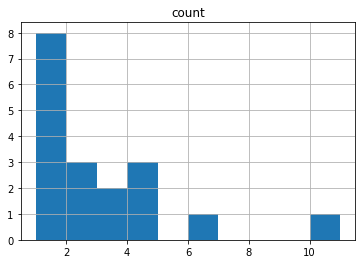

In [101]:
top_companies_p=top_companies_df.toPandas()
top_companies_p.hist('count')

In [103]:
#not working
#hdf = top_companies_df.toHandy()
#hdf.cols["autonomous_system_organization"].hist()

AttributeError: 'DataFrame' object has no attribute 'toHandy'

## Where are these companys located?

In [89]:
df_joint_all.join(top_companies,"autonomous_system_organization","right").select("autonogmous_system_organization","country_name","count").distinct().sort(desc("count")).show()

+------------------------------+------------+-----+
|autonomous_system_organization|country_name|count|
+------------------------------+------------+-----+
|                     SEDO GmbH|        null|   11|
|                 CLOUDFLARENET|        null|    6|
|           Hetzner Online GmbH|     Germany|    4|
|                   netcup GmbH|     Germany|    4|
|                     Strato AG|     Germany|    4|
|                  Wix.com Ltd.|        null|    3|
|           Deutsche Telekom AG|        null|    3|
|                  1&1 Ionos Se|     Germany|    2|
|              Team Internet AG|     Germany|    2|
|          Neue Medien Muenn...|     Germany|    2|
+------------------------------+------------+-----+



## How many websites use Cloudflare?


In [90]:
dfJoinA.filter(dfJoinA.autonomous_system_organization=='CLOUDFLARENET').show()


+------------------+--------------------+--------------------+-----+-------------+-------------+------------------------+------------------------------+--------------+------------+
|  Top level domain|           MX-Record|            A-Record|pos_A|        val_A|      network|autonomous_system_number|autonomous_system_organization|network_adress|subnetzmaske|
+------------------+--------------------+--------------------+-----+-------------+-------------+------------------------+------------------------------+--------------+------------+
|         0-9a-z.de|"[""mail.0-9a-z.d...|[104.24.103.72,10...|    0|104.24.103.72|104.16.0.0/12|                   13335|                 CLOUDFLARENET|    104.16.0.0|          12|
|         0-9a-z.de|"[""mail.0-9a-z.d...|[104.24.103.72,10...|    1|104.24.102.72|104.16.0.0/12|                   13335|                 CLOUDFLARENET|    104.16.0.0|          12|
|0-euro-flatrate.de|                  []|[104.27.165.83,10...|    0|104.27.165.83|104.16.0.0/12

In [91]:
dfJoinA.filter(dfJoinA.autonomous_system_organization=='CLOUDFLARENET').count()


6

## How many German websites use German hosting providers?


In [92]:
df_joint_all.filter(df_joint_all.country_name=="Germany").count()

15

In [93]:
dfJoinA.filter(dfJoinA.autonomous_system_organization.like('%Strato%')).show()
dfJoinA.filter(dfJoinA.autonomous_system_organization.like('%Strato%')).count()




+----------------+--------------------+---------------+-----+-------------+---------------+------------------------+------------------------------+--------------+------------+
|Top level domain|           MX-Record|       A-Record|pos_A|        val_A|        network|autonomous_system_number|autonomous_system_organization|network_adress|subnetzmaske|
+----------------+--------------------+---------------+-----+-------------+---------------+------------------------+------------------------------+--------------+------------+
|     0-100kmh.de|"[""smtpin.rzone....|[81.169.145.95]|    0|81.169.145.95|81.169.128.0/17|                    6724|                     Strato AG|  81.169.128.0|          17|
|         0-32.de|"[""smtpin.rzone....|[81.169.145.66]|    0|81.169.145.66|81.169.128.0/17|                    6724|                     Strato AG|  81.169.128.0|          17|
|     0-ahnung.de|"[""mail.0-ahnung...| [85.214.69.88]|    0| 85.214.69.88|  85.214.0.0/15|                    6724|    

4

In [94]:
dfJoinA.filter(dfJoinA.autonomous_system_organization.like('%Hetzner%')).count()


4

In [95]:
dfJoinA.filter(dfJoinA.autonomous_system_organization.like('%Mittwald%')).count()


0

Which email provider are used (MX record)?


In [96]:
#Idee: Fehler 'DataFrame' object has no attribute 'MX'

#dfJoinA.filter(dfJoinA.MX-Record=='%de').count()
#dfJoinA.filter(dfJoinA.MX-Record=='%en').count()
